In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner # 自作モジュール

In [2]:
names = [
    "race_id",
    "year",
    "month",
    "day",
    "times",
    "place",
    "daily",
    "race_num",
    "horse",
    "jockey_id",
    "horse_N",
    "waku_num",
    "horse_num",
    "class_code",
    "track_code",
    "corner_num",
    "dist",
    "state",
    "weather",
    "age_code",
    "sex",
    "age",
    "basis_weight",
    "blinker",
    "weight",
    "inc_dec",
    "weight_code",
    "win_odds",
    "rank",
    "time_diff",
    "time",
    "corner1_rank",
    "corner2_rank",
    "corner3_rank",
    "corner4_rank",
    "last_3F_time",
    "last_3F_rank",
    "Ave_3F",
    "PCI",
    "last_3F_time_diff",
    "leg",
    "pop",
    "prize",
    "error_code",
    "father",
    "mother",
    "id"
]

In [3]:
df2023 = pd.read_csv("../Data/record_data_2023.csv", encoding="shift-jis", header=None, names=names)
df2022 = pd.read_csv("../Data/record_data_2022.csv", encoding="shift-jis", header=None, names=names)
df2021 = pd.read_csv("../Data/record_data_2021.csv", encoding="shift-jis", header=None, names=names)
df = pd.concat([df2023, df2022, df2021])
df.tail()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,...,Ave_3F,PCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,id
47816,202109051004081207,21,9,5,4,小倉,8,12,ニシノトランザム,1171,...,37.71,52.2,0.1,先行,11.0,0,0,Orb,Glorious Success,2015110065
47817,202109051004081208,21,9,5,4,小倉,8,12,サマーカナロア,1168,...,38.04,57.5,1.2,後方,9.0,0,0,ロードカナロア,ノブクィーン,2018104097
47818,202109051004081209,21,9,5,4,小倉,8,12,ロックグラス,732,...,37.92,55.9,0.8,中団,8.0,0,0,エイシンフラッシュ,サトノコンドル,2017100368
47819,202109051004081210,21,9,5,4,小倉,8,12,レッドレイル,1115,...,37.83,54.2,0.5,先行,6.0,0,0,ディープインパクト,ナイトオブドバイ,2016105133
47820,202109051004081211,21,9,5,4,小倉,8,12,メイショウラツワン,666,...,37.74,57.2,0.2,先行,2.0,760,0,ルーラーシップ,ルサビ,2017102850


In [4]:
df2 = my_modules.common_process(df)
df2.head()

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:71: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


,year,month,day,times,place,daily,race_num,horse,jockey_id,horse_N,...,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3
19936,2021,1,5,1,中山,1,1,ネオトリニティー,1029,16,...,2018102289,2021010506010101,ダート,平地,R,中山ダート1200,inner,2021-01-05 01:02:00,0,0
19946,2021,1,5,1,中山,1,1,ジェラゾヴァヴォラ,1183,16,...,2018100256,2021010506010101,ダート,平地,R,中山ダート1200,outer,2021-01-05 01:02:00,0,0
19947,2021,1,5,1,中山,1,1,トランセンドパスト,1118,16,...,2018101171,2021010506010101,ダート,平地,R,中山ダート1200,outer,2021-01-05 01:02:00,0,0
19948,2021,1,5,1,中山,1,1,マイネルレスペト,1009,16,...,2018102803,2021010506010101,ダート,平地,R,中山ダート1200,outer,2021-01-05 01:02:00,0,0
19949,2021,1,5,1,中山,1,1,リュヌダムール,1177,16,...,2018103708,2021010506010101,ダート,平地,R,中山ダート1200,outer,2021-01-05 01:02:00,0,1


In [20]:
def feature_engineering(df_to_copy, feature_col_to_copy=None):
    if feature_col_to_copy == None :
        feature_col_to_copy = ["waku_num", "horse_num", "sex", "age", "basis_weight", "blinker", "weight", "inc_dec"]
    feature_col = feature_col_to_copy.copy()
    df = df_to_copy.copy()

    # 直近3レースの結果とその平均, 過去全てのレースの記録の平均を追加
    last_race_col = ["weight", "inc_dec", "last_3F_time", "Ave_3F", "PCI"]
    for col in last_race_col:
        grouped = df.groupby("horse", observed=True)[col]
        for i in range(1, 4):
            # 過去1-3レースの結果を追加
            colname = f"{col}_last_{i}"
            df[colname] = grouped.shift(1)
            feature_col.append(colname)
        
        # 過去3レース分の結果の平均を追加
        df[f"{col}_mean_last_1_to_3"] = df[[f"{col}_last_{i}" for i in range(1, 4)]].mean(axis=1, skipna=True)
        feature_col.append(f"{col}_mean_last_1_to_3")

        # 過去全レース文の特徴量を追加
        cumsum = grouped.cumsum()
        count = grouped.cumcount()
        df[f"{col}_mean_all"] = (cumsum - df[col]) / count.replace(0, np.nan)
        feature_col.append(f"{col}_mean_all")


    # 過去その馬の全てのレースの1着率
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["horse"])

    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["field_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["turn_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["basis_weight"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["age_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weight_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "field_type"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["jockey_id", "place", "field_type", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["weather", "state"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "corner_num"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "track_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["dist", "class_code"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist"])
    df, feature_col = grouped_horse_winning_rate(df, feature_col, cols=["place", "field_type", "dist", "class_code"])

    # 過去他の馬も含む全レースで同条件でのレースの1着の確率
    # dist, field_type, place, race_type系
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["place", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["place", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["place", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "dist", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "dist", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "dist", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "place", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "place", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["dist", "place", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "place", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "place", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["field_type", "place", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["race_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["race_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["race_type", "horse_num"])


    # leg系(リーク情報なので一旦停止)
    '''
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "dist"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "place"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "field_type"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "place", "field_type"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "place", "dist"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "dist", "field_type"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg","race_type"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "race_type", "waku"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg", "race_type", "waku_num"])
    df, feature_col = grouped_leg_winning_rate(df, feature_col, cols=["leg","race_type", "horse_num"])
    '''

    # jockey_id系
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "place"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "place", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "field_type", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "field_type", "place"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "race_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "race_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "race_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "race_type", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "place"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "race_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "race_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "race_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "class_code", "race_type", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "turn_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["jockey_id", "turn_type", "dist"])


    # mother系
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "turn_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "race_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "track_code"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "class_code"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "corner_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "dist", "field_type"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place", "dist", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place", "dist", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "place", "dist", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "dist", "field_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "dist", "field_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "dist", "field_type", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "field_type", "place", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "field_type", "place", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "field_type", "place", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "race_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "race_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["mother", "race_type", "horse_num"])
    
    # father系
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "turn_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "race_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "track_code"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "class_code"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "corner_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place", "dist"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place", "field_type"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "dist", "field_type"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place", "dist", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place", "dist", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "place", "dist", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "dist", "field_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "dist", "field_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "dist", "field_type", "horse_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "field_type", "place", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "field_type", "place", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "field_type", "place", "horse_num"])

    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "race_type", "waku"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "race_type", "waku_num"])
    df, feature_col = grouped_winning_rate(df, feature_col, cols=["father", "race_type", "horse_num"])
    


    # その他特徴量を追加
    # weightに関する特徴量
    # weightは300kg以下の馬がいないことからこのようにした。
    df["basis_weight_per_weight"] = df["basis_weight"] / df["weight"].clip(lower=300) * 100 # 斤量/馬体重（％）
    feature_col.append("basis_weight_per_weight")
    df["basis_weight_plus_weight"] = df["basis_weight"] + df["weight"] # 斤量＋馬体重
    feature_col.append("basis_weight_plus_weight")
    df["inc_dec_rate"] = df["inc_dec"] / df["weight"].clip(lower=300) * 100 # 増減/馬体重（％）
    feature_col.append("inc_dec_rate")

    # 生涯獲得賞金
    df["lifetime_prize"] = df.groupby("horse", observed=True)["prize"].cumsum() - df["prize"]
    feature_col.append("lifetime_prize")
    
    # 前回と同じfield_typeかどうか
    df["last_field_type"] = df.groupby(["horse"], observed=True)["field_type"].shift(1)
    feature_name = "is_same_field_type_as_last"
    df[feature_name] =  df["field_type"] == df["last_field_type"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_field_type"], axis=1)
    feature_col.append(feature_name)

    # 前回と同じクラスか
    df["last_class_code"] = df.groupby(["horse"], observed=True)["class_code"].shift(1)
    feature_name = "is_same_class_code_as_last"
    df[feature_name] = df["class_code"] == df["last_class_code"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_class_code"], axis=1)
    feature_col.append(feature_name)

    # 前回と同じジョッキーか
    df["last_jockey"] = df.groupby(["horse"], observed=True)["jockey_id"].shift(1)
    feature_name = "is_same_jockey_as_last"
    df[feature_name] = df["jockey_id"] == df["last_jockey"]
    df[feature_name] = df[feature_name].astype("category")
    df = df.drop(["last_jockey"], axis=1)
    feature_col.append(feature_name)

    # 中何日か
    df["last_race_date"] = df.groupby("horse", observed=True)["datetime"].shift(1)
    df["interval"] = df["datetime"] - df["last_race_date"]
    df["interval_day"] = df["interval"].dt.days
    df["interval_week"] = df["interval_day"] // 7
    df = df.drop(["last_race_date", "interval"], axis=1)
    feature_col.append("interval_day")
    feature_col.append("interval_week")


    # 最後に全体を正規化（std=1とする)
    num_col = df[feature_col].select_dtypes(include=["number"]).columns.tolist()
    grouped_mean = df.groupby("id_for_fold", observed=True)[num_col].transform("mean")
    grouped_std = df.groupby("id_for_fold", observed=True)[num_col].transform("std")
    df[num_col] = (df[num_col] - grouped_mean) / grouped_std

    # 後でランキング化とかも付ける予定

    # dfを表示
    print(feature_col)
    display(df.tail())

    return df, feature_col


# 馬でグループ化したtarget-encodingをする関数
def grouped_horse_winning_rate(df_to_copy, feature_col_to_copy, cols=None):
    df = df_to_copy.copy()
    feature_col = feature_col_to_copy.copy()

    if cols == None :
        print("Error: please select cols")
        return
    
    # 1着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "horse_win_rate_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    # 1-3着の確率で計算
    grouped = df.groupby(["horse", *cols], observed=True)["target3"]
    cumsum = grouped.cumsum()
    count = grouped.cumcount()
    feature_name = "horse_win_rate3_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target3"]) / count.replace(0, np.nan)

    feature_col.append(feature_name)

    return df, feature_col


# 過去全てのレースでグループ化したtarget-encodingをする関数
def grouped_winning_rate(df_to_copy, feature_col_to_copy, cols):
    df = df_to_copy.copy()
    feature_col = feature_col_to_copy.copy()

    # 同じ条件で1着になるの確率を計算
    grouped = df.groupby(cols, observed=True)["target"]
    count = grouped.cumcount()
    cumsum = grouped.cumsum()
    feature_name = "all_win_rate_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target"]) / count.replace(0, np.nan)
    feature_col.append(feature_name)

    # 同じ条件で1-3着になるの確率を計算
    grouped = df.groupby(cols, observed=True)["target3"]
    count = grouped.cumcount()
    cumsum = grouped.cumsum()
    feature_name = "all_win_rate3_" + "_".join(cols)
    df[feature_name] = (cumsum-df["target3"]) / count.replace(0, np.nan)
    feature_col.append(feature_name)

    return df, feature_col


In [21]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "blinker", "weight", "inc_dec"]
df3, feature_col2 = feature_engineering(df2, feature_col)
df3 = df3[df3.year == 2023]

['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'blinker', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'PCI_last_1', 'PCI_last_2', 'PCI_last_3', 'PCI_mean_last_1_to_3', 'PCI_mean_all', 'all_win_rate_horse', 'all_win_rate3_horse', 'horse_win_rate_dist', 'horse_win_rate3_dist', 'horse_win_rate_track_code', 'horse_win_rate3_track_code', 'horse_win_rate_field_type', 'horse_win_rate3_field_type', 'horse_win_rate_turn_type', 'horse_win_rate3_turn_type', 'horse_win_rate_weather', 'horse_win_rate3_weather', 'horse_win_rate_state', 'horse_win_rate3_state', 'horse_win_rate_place', 'horse_win_rat

,year,month,day,times,place,daily,race_num,horse,jockey_id,horse_N,...,all_win_rate3_father_race_type_horse_num,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,interval_week
43875,2023,12,28,5,阪神,9,12,テイエムイダテン,1144,16,...,-0.036142,-0.065131,0.510481,2.100688,-1.662749,True,True,False,1.302078,1.297078
43876,2023,12,28,5,阪神,9,12,ハギノメーテル,1138,16,...,NaN,-1.494779,0.800458,1.381712,-0.876352,True,True,True,-0.351695,-0.357166
43877,2023,12,28,5,阪神,9,12,クムシラコ,1112,16,...,NaN,1.025430,-0.359451,-1.036144,-0.645983,True,False,False,-0.212091,-0.206781
43869,2023,12,28,5,阪神,9,12,マイネルレノン,1199,16,...,-0.397562,1.279169,-0.552769,-0.680423,-0.043358,True,True,False,1.302078,1.297078
43874,2023,12,28,5,阪神,9,12,アネゴハダ,1186,16,...,-0.758981,0.001723,-0.456110,1.116584,2.143579,True,True,True,-0.577210,-0.582745


[I 2025-06-06 18:26:42,776] A new study created in memory with name: no-name-b7648cad-ca83-4587-b781-11ecbe5c1602
[I 2025-06-06 18:26:44,751] Trial 0 finished with value: 0.21253524139807367 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.21253524139807367.
[I 2025-06-06 18:26:53,335] Trial 1 finished with value: 0.17091015079190297 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambd

Best params :  {'max_bin': 209, 'num_leaves': 60, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2.03752435516422, 'bagging_fraction': 0.9436245059626859, 'bagging_freq': 66, 'feature_fraction': 0.12767993869750757, 'lambda_l1': 2.1711773173075966e-08, 'lambda_l2': 0.5028934482291424, 'min_gain_to_split': 1.042424102291235, 'max_depth': 49, 'learning_rate': 0.018018897585229978, 'path_smooth': 6.497319183808647}


Sum of predict      is : 281
Sum of predict rate is : 0.0206800118


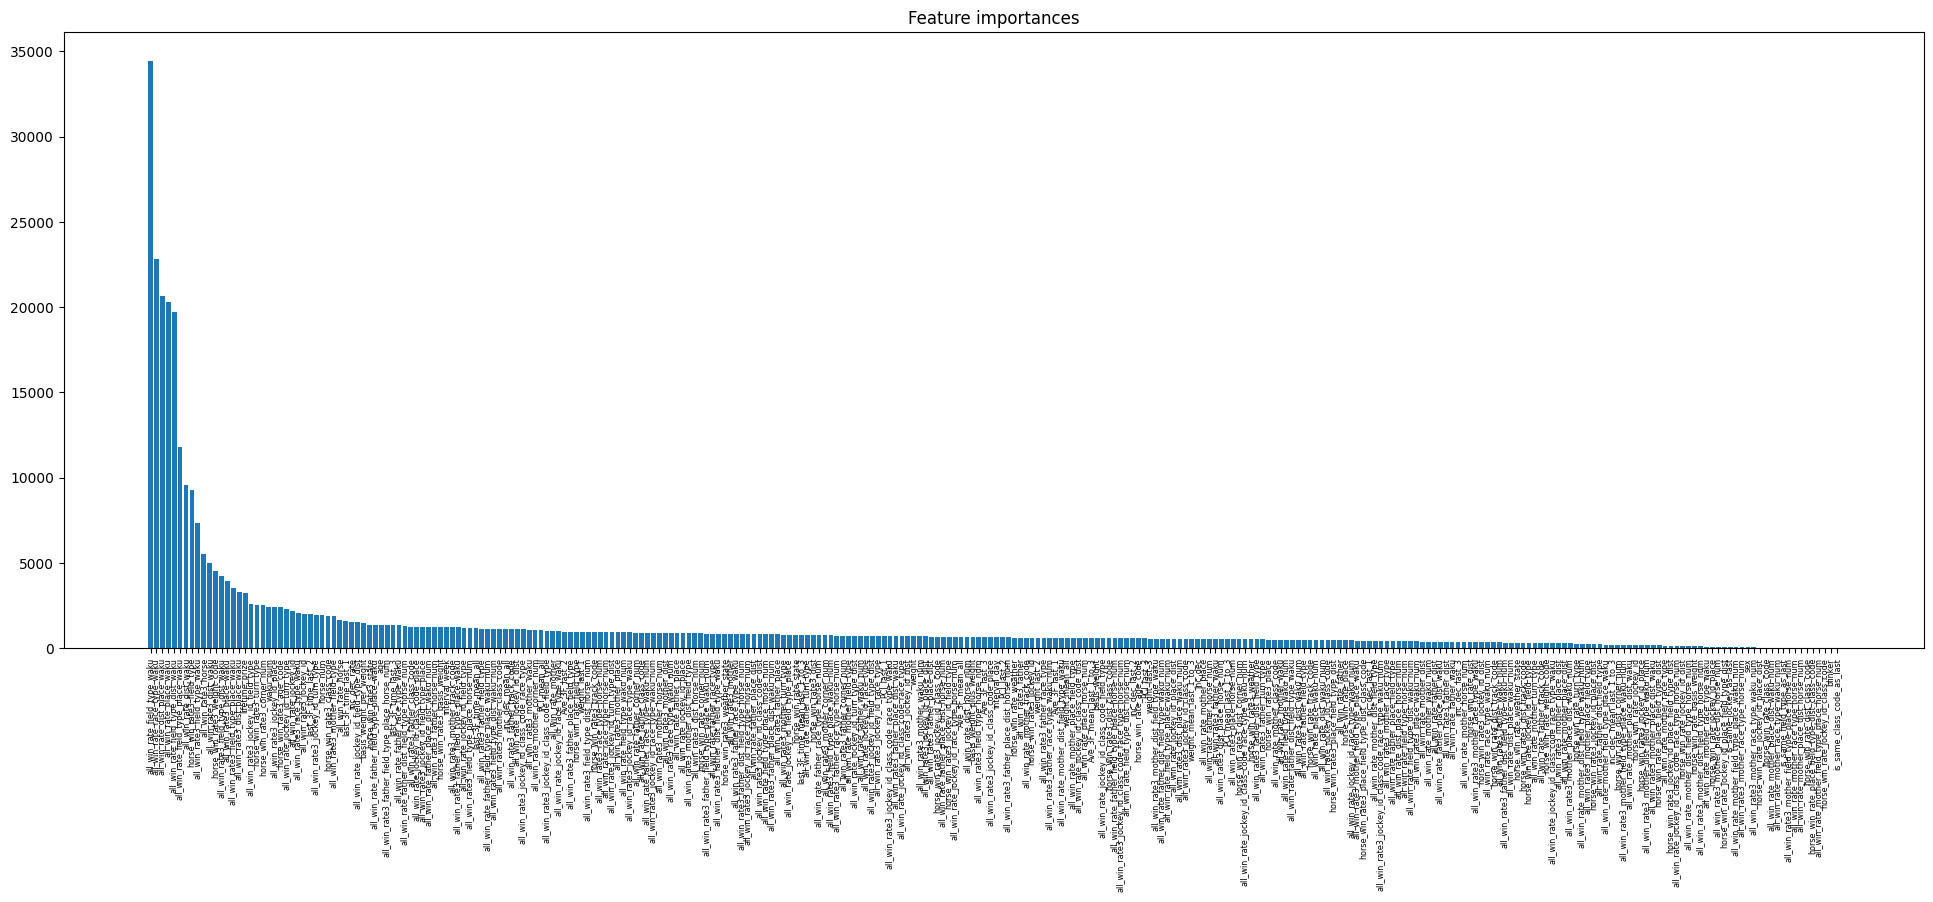

,date,memo,horse_5,horse_6,horse7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,sum_of_logloss,roc_auc_score
0,2025/06/06 18:56,"add last race results, bloods infomation with ...",0.272439,0.299833,0.375014,0.232825,0.237270,0.193202,0.194682,0.169712,0.153252,0.121900,0.109691,0.082961,0.137132,0.126652,2.706566,0.936413
1,2025/06/06 17:08,add last race results with standardize. n_rial...,0.266476,0.336182,0.352209,0.183488,0.233655,0.193565,0.192630,0.164785,0.151873,0.119273,0.107444,0.082788,0.136866,0.121472,2.642704,0.933049
2,2025/06/06 16:48,add last race results with standardize(std=1)....,0.227307,0.377179,0.366196,0.297622,0.326539,0.280133,0.267366,0.245015,0.233414,0.205238,0.212895,0.204126,0.184350,0.197393,3.624774,0.776897
3,2025/06/06 16:29,"add last race results, no standardize. n_rials...",0.305460,0.374207,0.375615,0.301635,0.326611,0.278111,0.265834,0.246874,0.234568,0.215178,0.218472,0.205115,0.194307,0.200001,3.741987,0.758212
4,2025/06/06 15:58,No feature engineering with data minus grouped...,0.462857,0.462231,0.402017,0.364059,0.336218,0.308494,0.295284,0.278313,0.263321,0.248877,0.239511,0.226982,0.210889,0.211045,4.310097,0.642231
5,2025/06/06 15:29,No feature engineering with yeo-johnson-transf...,0.461397,0.470164,0.397626,0.369435,0.344003,0.312507,0.297227,0.279669,0.266719,0.250942,0.239750,0.229268,0.213745,0.211244,4.343695,0.621086
6,2025/06/06 15:16,No feature engineering. n_rials=100.,0.461984,0.489677,0.392669,0.372894,0.345458,0.312119,0.298260,0.278618,0.268310,0.252885,0.242601,0.230501,0.214274,0.213532,4.373781,0.613889


In [22]:
memo = "add last race results, bloods infomation with standardize. n_rials=100."
model = model_tuner.simple_lightGBM(df3, feature_col2, memo=memo, n_trials=100, save_result=True, visualization=True)

In [16]:
pd.set_option('display.max_info_columns', 300)

In [17]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46137 entries, 19443 to 43874
Data columns (total 225 columns):
 #    Column                                                  Non-Null Count  Dtype         
---   ------                                                  --------------  -----         
 0    year                                                    46137 non-null  int64         
 1    month                                                   46137 non-null  int64         
 2    day                                                     46137 non-null  int64         
 3    times                                                   46137 non-null  int64         
 4    place                                                   46137 non-null  category      
 5    daily                                                   46137 non-null  category      
 6    race_num                                                46137 non-null  int64         
 7    horse                                           